In [1]:
# import dependencies
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
import joblib

In [2]:
data = pd.read_csv('data/internet_service_churn.csv')
data.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,15,1,0,11.95,25,0.14,0,8.4,2.3,0,0
1,18,0,0,8.22,0,NaN,0,0.0,0.0,0,1
2,23,1,0,8.91,16,0.00,0,13.7,0.9,0,1
3,27,0,0,6.87,21,NaN,1,0.0,0.0,0,1
4,34,0,0,6.39,0,NaN,0,0.0,0.0,0,1


In [3]:
# Assuming df is your loaded DataFrame and 'churn' is the target column
train_df, test_df = train_test_split(
    data,
    test_size=0.10,           # 10% for testing
    stratify=data['churn'],     # preserve churn class ratio
    random_state=42           # for reproducibility
)

# Save to CSV
train_df.to_csv('data/internet_service_churn_train.csv', index=False)
test_df.to_csv('data/internet_service_churn_test.csv', index=False)

In [4]:
base_dir = os.getcwd()
transformer_path = os.path.join(base_dir, "saved", "transformer")
scaler_path = os.path.join(base_dir, "saved", "scaler")
model_path = os.path.join(base_dir, "saved", "model")
preprocessing_path = os.path.join(base_dir, "saved", "preprocessing")

os.makedirs(transformer_path, exist_ok=True)
os.makedirs(scaler_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
os.makedirs(preprocessing_path, exist_ok=True)

In [5]:
df = pd.read_csv('data/internet_service_churn_train.csv')
df.head()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,822409,0,0,0.98,18,0.00,0,19.1,1.2,0,1
1,1506890,1,0,1.00,9,1.22,0,8.6,0.7,0,1
2,608799,1,0,5.22,22,NaN,0,8.6,1.0,3,1
3,528872,1,0,1.97,23,0.00,0,5.0,0.6,0,1
4,1499514,1,1,0.73,15,1.25,0,174.0,34.4,0,0


In [6]:
df.shape

(65046, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65046 entries, 0 to 65045
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           65046 non-null  int64  
 1   is_tv_subscriber             65046 non-null  int64  
 2   is_movie_package_subscriber  65046 non-null  int64  
 3   subscription_age             65046 non-null  float64
 4   bill_avg                     65046 non-null  int64  
 5   reamining_contract           45662 non-null  float64
 6   service_failure_count        65046 non-null  int64  
 7   download_avg                 64709 non-null  float64
 8   upload_avg                   64709 non-null  float64
 9   download_over_limit          65046 non-null  int64  
 10  churn                        65046 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 5.5 MB


In [8]:
df.describe()

,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
count,6.504600e+04,65046.000000,65046.000000,65046.000000,65046.000000,45662.000000,65046.000000,64709.000000,64709.000000,65046.000000,65046.000000
mean,8.464571e+05,0.816053,0.333902,2.449882,18.940534,0.714749,0.275236,43.642218,4.195511,0.207545,0.554146
std,4.885011e+05,0.387444,0.471609,2.036714,13.305575,0.696964,0.820330,63.951991,9.940926,0.996328,0.497063
min,1.500000e+01,0.000000,0.000000,-0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.233382e+05,1.000000,0.000000,0.930000,13.000000,0.000000,0.000000,6.700000,0.500000,0.000000,0.000000
50%,8.485070e+05,1.000000,0.000000,1.980000,19.000000,0.570000,0.000000,27.700000,2.100000,0.000000,1.000000
75%,1.268356e+06,1.000000,1.000000,3.290000,22.000000,1.310000,0.000000,60.400000,4.800000,0.000000,1.000000
max,1.689744e+06,1.000000,1.000000,12.800000,406.000000,2.870000,19.000000,4415.200000,453.300000,7.000000,1.000000


In [9]:
df.columns

Index(['id', 'is_tv_subscriber', 'is_movie_package_subscriber',
       'subscription_age', 'bill_avg', 'reamining_contract',
       'service_failure_count', 'download_avg', 'upload_avg',
       'download_over_limit', 'churn'],
      dtype='object')

In [10]:
# check for class imbalance
df['churn'].value_counts()

churn
1    36045
0    29001
Name: count, dtype: int64

In [11]:
# drop all rows with subscription_age <0
df = df[df['subscription_age'] >= 0]

In [12]:
# check the shape of the dataset
df.shape

(65045, 11)

In [13]:
# drop unnecessary columns
df.drop(['id'], axis = 1, inplace = True)

In [14]:
df[(df['reamining_contract'].isna()) & (df['churn'] == 0)].shape

(1668, 10)

In [15]:
df[(df['reamining_contract'].isna()) & (df['churn'] == 1)].shape

(17716, 10)

In [16]:
df[(df['reamining_contract']==0.0) & (df['churn'] == 0)].shape

(66, 10)

In [17]:
df[(df['reamining_contract']==0.0) & (df['churn'] == 1)].shape

(14704, 10)

In [18]:
# fill all NaN in reamining_contract with 0.0 since most of the rows with reamining_contract of 0.0 and NaN have churn of 1
df['reamining_contract'].fillna(0.0, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_15424\2674295286.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['reamining_contract'].fillna(0.0, inplace=True)


In [19]:
df[(df['download_avg'].isna()) & (df['churn'] == 0)].shape

(337, 10)

In [20]:
df[(df['download_avg'].isna()) & (df['churn'] == 1)].shape

(0, 10)

In [21]:
df[(df['download_avg']==0.0) & (df['churn'] == 0)].shape

(22, 10)

In [22]:
df[(df['download_avg']==0.0) & (df['churn'] == 1)].shape

(9859, 10)

In [23]:
df[(df['download_avg'].isna()) & (~df['upload_avg'].isna())]

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn


In [24]:
df[(~df['download_avg'].isna()) & (df['upload_avg'].isna())]


,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn


In [25]:
# During training
download_avg_mean = df['download_avg'].mean()

# Fill missing with training mean
df['download_avg'].fillna(download_avg_mean, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_15424\979244447.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['download_avg'].fillna(download_avg_mean, inplace=True)


In [26]:
# During training
upload_avg_mean = df['upload_avg'].mean()

# Fill missing with training mean
df['upload_avg'].fillna(upload_avg_mean, inplace=True)

preprocessing_data = {
    "download_avg_mean": download_avg_mean,
    "upload_avg_mean": upload_avg_mean
}

with open(os.path.join(preprocessing_path, "preprocessing.pkl"), "wb") as f:
    joblib.dump(preprocessing_data, f)

C:\Users\User\AppData\Local\Temp\ipykernel_15424\706514178.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['upload_avg'].fillna(upload_avg_mean, inplace=True)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65045 entries, 0 to 65045
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   is_tv_subscriber             65045 non-null  int64  
 1   is_movie_package_subscriber  65045 non-null  int64  
 2   subscription_age             65045 non-null  float64
 3   bill_avg                     65045 non-null  int64  
 4   reamining_contract           65045 non-null  float64
 5   service_failure_count        65045 non-null  int64  
 6   download_avg                 65045 non-null  float64
 7   upload_avg                   65045 non-null  float64
 8   download_over_limit          65045 non-null  int64  
 9   churn                        65045 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 5.5 MB


In [28]:
def detect_and_handle_outliers(df, columns=None, remove=False):
    """
    Detects and optionally removes outliers from a DataFrame using the IQR method.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list, optional): List of columns to check for outliers.
                                  If None, all numeric columns are considered.
        remove (bool): If True, removes rows containing outliers.

    Returns:
        pd.DataFrame: DataFrame with or without outliers removed
    """
    
    # If no columns are provided, consider all numeric columns
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns.tolist()
    
    df_out = df.copy()
    
    for col in columns:
        if col not in df_out.columns:
            print(f"⚠️ Column '{col}' not found in DataFrame. Skipping.")
            continue
        
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outlier_mask = (df_out[col] < lower_bound) | (df_out[col] > upper_bound)
        num_outliers = outlier_mask.sum()
        
        print(f"Column '{col}': {num_outliers} outliers detected.")
        
        if remove and num_outliers > 0:
            df_out = df_out[~outlier_mask]
    
    return df_out

# Only detect outliers
detect_and_handle_outliers(df, columns=['subscription_age', 'bill_avg', 'reamining_contract', 'download_avg', 'upload_avg'])

# Detect and remove outliers
# df_clean = detect_and_handle_outliers(df, remove=True)

Column 'subscription_age': 2969 outliers detected.
Column 'bill_avg': 3010 outliers detected.
Column 'reamining_contract': 12 outliers detected.
Column 'download_avg': 3175 outliers detected.
Column 'upload_avg': 4387 outliers detected.


,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,0,0,0.98,18,0.00,0,19.1,1.2,0,1
1,1,0,1.00,9,1.22,0,8.6,0.7,0,1
2,1,0,5.22,22,0.00,0,8.6,1.0,3,1
3,1,0,1.97,23,0.00,0,5.0,0.6,0,1
4,1,1,0.73,15,1.25,0,174.0,34.4,0,0
...,...,...,...,...,...,...,...,...,...,...
65041,0,0,0.30,18,0.00,0,29.8,1.7,0,1
65042,1,1,1.76,12,0.21,0,56.3,2.4,0,0
65043,1,0,2.01,12,0.94,0,71.3,5.5,0,0
65044,1,1,0.93,23,0.00,0,44.4,2.5,0,1


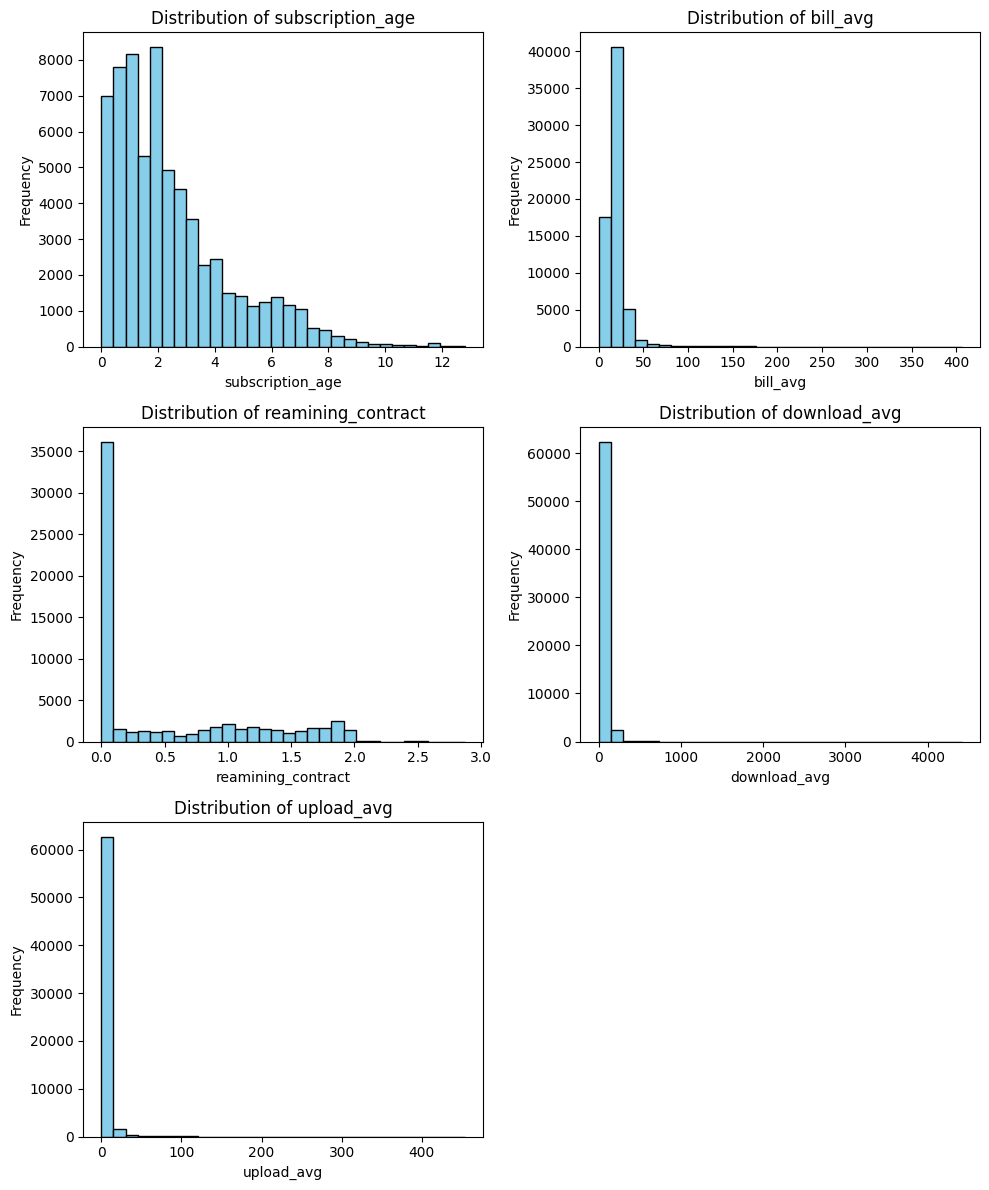

In [29]:
def plot_distributions(df, columns=None, bins=30):
    """
    Plots histograms for each column in the DataFrame.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list, optional): List of columns to plot. 
                                  If None, all numeric columns are considered.
        bins (int): Number of bins for the histogram.
    """
    if columns is None:
        columns = df.select_dtypes(include=['number']).columns.tolist()
    
    num_cols = len(columns)
    plt.figure(figsize=(5 * 2, 4 * ((num_cols + 1) // 2)))  # Adjust size
    
    for i, col in enumerate(columns, 1):
        plt.subplot((num_cols + 1) // 2, 2, i)
        plt.hist(df[col].dropna(), bins=bins, color='skyblue', edgecolor='black')
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

# Plot all non-binary numeric columns
plot_distributions(df, columns=['subscription_age', 'bill_avg', 'reamining_contract', 'download_avg', 'upload_avg'])

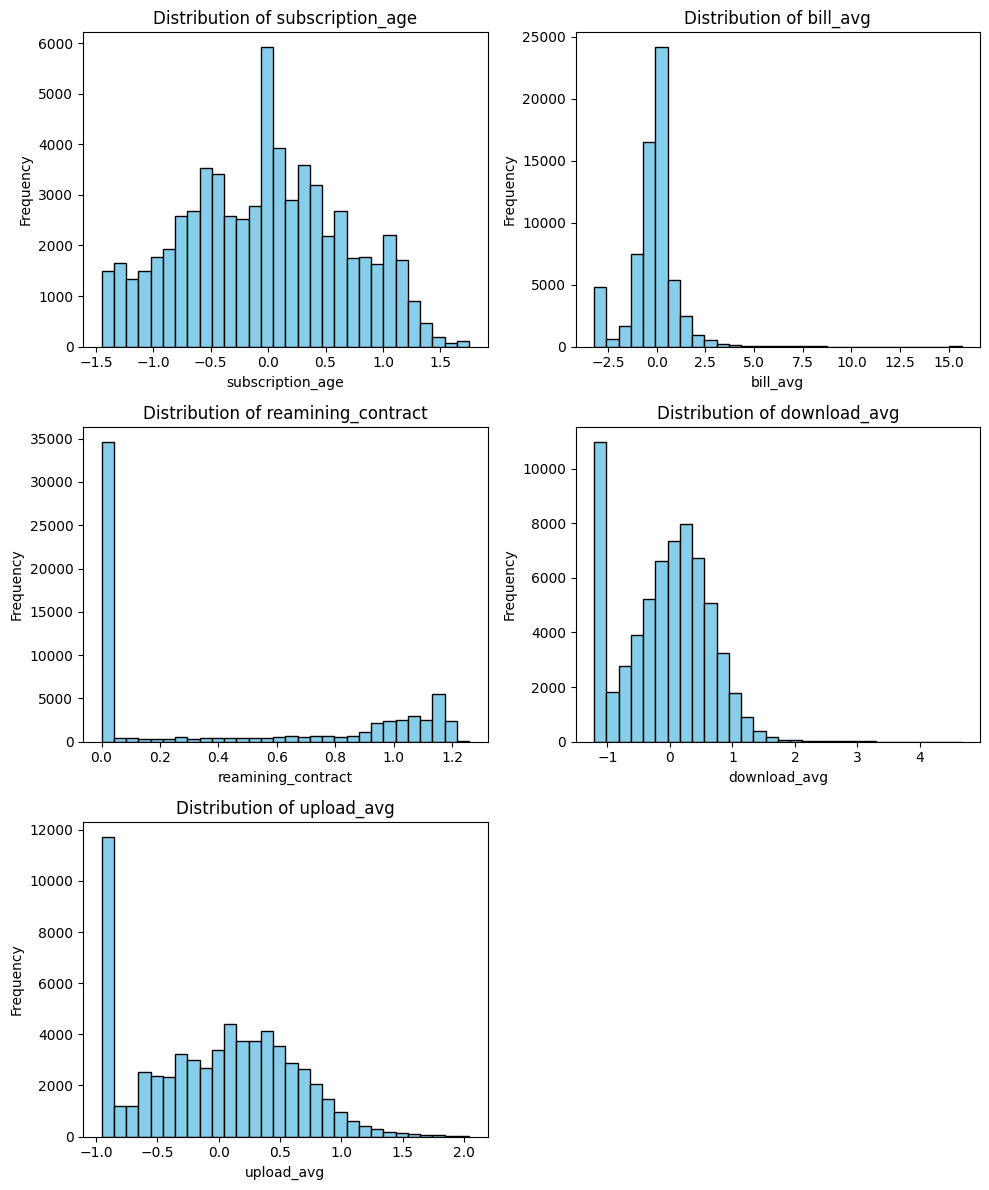

In [30]:
# Columns to transform & scale
skewed_cols = ['subscription_age', 'bill_avg', 'reamining_contract',
               'download_avg', 'upload_avg']

# reduce skew (Yeo–Johnson works with zeros & negatives)
pt = PowerTransformer(method='yeo-johnson')
df[skewed_cols] = pt.fit_transform(df[skewed_cols])

# robust scaling
rs = RobustScaler()
df[skewed_cols] = rs.fit_transform(df[skewed_cols])

joblib.dump(pt, os.path.join(transformer_path, "transformer.pkl"))
joblib.dump(rs, os.path.join(scaler_path, "scaler.pkl"))

# plot all non-binary numeric columns again
plot_distributions(df, columns=['subscription_age', 'bill_avg', 'reamining_contract', 'download_avg', 'upload_avg'])

C:\Users\User\AppData\Local\Temp\ipykernel_15424\3583597048.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='correlation', y='feature', data=corr_df, palette='vlag')


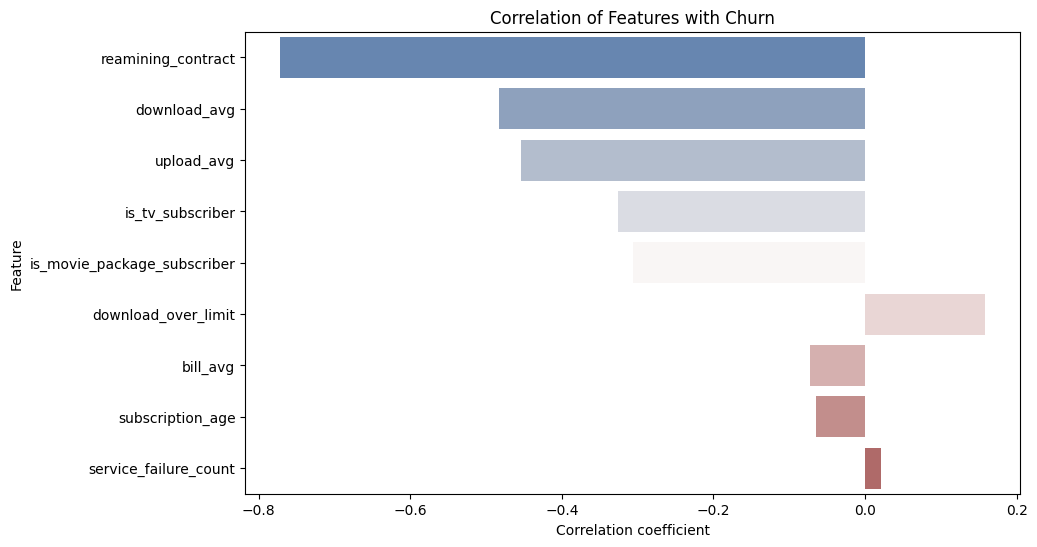

In [31]:
# Compute correlation of all numeric columns with 'churn'
corr = df.corr()['churn'].drop('churn')  # drop churn's correlation with itself

# Convert to DataFrame for easy plotting
corr_df = corr.reset_index()
corr_df.columns = ['feature', 'correlation']

# Sort by absolute correlation value descending
corr_df['abs_correlation'] = corr_df['correlation'].abs()
corr_df = corr_df.sort_values(by='abs_correlation', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='correlation', y='feature', data=corr_df, palette='vlag')
plt.title('Correlation of Features with Churn')
plt.xlabel('Correlation coefficient')
plt.ylabel('Feature')
plt.show()

## Training ML Model

In [32]:
# split dataset into X and y
X = df.drop(columns=['churn'])
y = df['churn']

### Base Model

In [33]:
# Logistic Regression model
model = LogisticRegression(max_iter=1000)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation accuracies: [0.89699439 0.90099162 0.90814052 0.90345146 0.8987624 ]
Mean accuracy: 0.901668075947421


### Random Forest Classifier

In [34]:
# Random Forest Classifier model
model = RandomForestClassifier(random_state=42)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation accuracies: [0.93873472 0.94442309 0.94288569 0.94042586 0.9390422 ]
Mean accuracy: 0.9411023137827659


### Gradient Boosting Machines

In [35]:
# XGBoost Classifier model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Cross-validation accuracies: [0.94027212 0.94350065 0.94442309 0.942117   0.9405796 ]
Mean accuracy: 0.94217849181336


h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [36]:
# LightGBM Classifier model
model = LGBMClassifier(random_state=42, verbose=-1)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation accuracies: [0.93988777 0.94511492 0.94403874 0.94242448 0.94150204]
Mean accuracy: 0.9425935890537321


### Other Algorithms

In [37]:
# K-nearest Neighbor model
model = KNeighborsClassifier(n_neighbors=5)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation accuracies: [0.90913983 0.91598124 0.9173649  0.91436698 0.91190714]
Mean accuracy: 0.9137520178338073


In [38]:
# Naive Bayes model
model = GaussianNB()

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation accuracies: [0.83634407 0.83203936 0.83273119 0.83311554 0.83403797]
Mean accuracy: 0.8336536244138673


### Neural Network

In [39]:
# MLP model
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation accuracies: [0.93512184 0.93950342 0.94042586 0.93704359 0.93558306]
Mean accuracy: 0.9375355523099392


## Hyperparameter Optimization
The best performing model is `XGBoost`

In [40]:
# Cross-validation setup
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective(trial):
    # Suggest hyperparameters to tune
    params = {
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }
    
    model = XGBClassifier(**params)
    
    # Cross-validate using accuracy
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    
    # Return the mean accuracy (to maximize)
    return np.mean(scores)

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)  # You can increase n_trials for better results

print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-08-11 19:52:16,952] A new study created in memory with name: no-name-5d655777-f96f-4122-9160-06610515d4f0
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:52:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:52:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:52:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\

Best trial:
  Accuracy: 0.9444
  Params: 
    n_estimators: 262
    max_depth: 11
    learning_rate: 0.07903250644640547
    subsample: 0.9374984378317079
    colsample_bytree: 0.5885757039454472
    gamma: 0.7888768453561348
    min_child_weight: 2
    reg_alpha: 0.9706378698186557
    reg_lambda: 0.26075838439604215


In [41]:
trial.params

{'n_estimators': 262,
 'max_depth': 11,
 'learning_rate': 0.07903250644640547,
 'subsample': 0.9374984378317079,
 'colsample_bytree': 0.5885757039454472,
 'gamma': 0.7888768453561348,
 'min_child_weight': 2,
 'reg_alpha': 0.9706378698186557,
 'reg_lambda': 0.26075838439604215}

In [50]:
# params = {
#     'n_estimators': 455,
#     'max_depth': 12,
#     'learning_rate': 0.04483108449156433,
#     'subsample': 0.9560267708761696,
#     'colsample_bytree': 0.841744697376477,
#     'gamma': 0.6501347291565536,
#     'min_child_weight': 1,
#     'reg_alpha': 1.4175185668432175,
#     'reg_lambda': 1.516289914133435
# }

# XGBoost Classifier model
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **trial.params)

# Cross-validation setup (StratifiedKFold keeps class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Accuracy scores across folds
scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

# Fit model on the full dataset after cross-validation
model.fit(X, y)

# savel model and a .pkl file
joblib.dump(model, os.path.join(model_path, "model.pkl"))

print("Cross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))

h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:58:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
h:\DS\top-5\customer-churn-prediction\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:58:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:7

Cross-validation accuracies: [0.94242448 0.94642171 0.94634484 0.94327004 0.94342378]
Mean accuracy: 0.9443769697901452


## Testing on Unseen Data

In [51]:
# Load the test dataset
test_df = pd.read_csv('data/internet_service_churn_test.csv')
print(f"Test dataset shape: {test_df.shape}")
test_df.head()

Test dataset shape: (7228, 11)


,id,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,reamining_contract,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,568859,1,1,1.87,10,NaN,0,0.0,0.0,0,1
1,932837,1,1,3.22,24,0.72,0,53.8,2.4,0,0
2,157220,0,0,3.35,0,NaN,0,2.1,0.2,6,1
3,1375923,1,0,1.13,20,0.85,0,179.3,7.5,0,0
4,704279,1,0,0.60,23,NaN,0,23.0,1.9,0,1


In [52]:
# Prepare test data (same preprocessing as training data)
# Drop ID column if it exists
if 'id' in test_df.columns:
    test_df = test_df.drop(['id'], axis=1)

with open(os.path.join(preprocessing_path, "preprocessing.pkl"), "rb") as f:
    preprocessing_data = joblib.load(f)


# Fill missing values (same logic as training data)
test_df['reamining_contract'].fillna(0.0, inplace=True)
test_df['download_avg'].fillna(preprocessing_data['download_avg_mean'], inplace=True)
test_df['upload_avg'].fillna(preprocessing_data['upload_avg_mean'], inplace=True)

# Apply same transformations and scaling
skewed_cols = ['subscription_age', 'bill_avg', 'reamining_contract',
               'download_avg', 'upload_avg']


# Load saved pkl files
pt = joblib.load(os.path.join(transformer_path, "transformer.pkl"))
rs = joblib.load(os.path.join(scaler_path, "scaler.pkl"))
model = joblib.load(os.path.join(model_path, "model.pkl"))

test_df[skewed_cols] = pt.transform(test_df[skewed_cols])
test_df[skewed_cols] = rs.transform(test_df[skewed_cols])

print("Test data preprocessing completed!")

Test data preprocessing completed!


C:\Users\User\AppData\Local\Temp\ipykernel_15424\14322779.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['reamining_contract'].fillna(0.0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_15424\14322779.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For 

In [53]:
# Make predictions on test set
X_test = test_df.drop(columns=['churn'])
y_test = test_df['churn']

# Get predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of churn

print(f"Test set predictions completed!")
print(f"Number of test samples: {len(y_test)}")
print(f"Number of predicted churn: {sum(y_pred)}")
print(f"Number of actual churn: {sum(y_test)}")

Test set predictions completed!
Number of test samples: 7228
Number of predicted churn: 3962
Number of actual churn: 4005


In [54]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("=== MODEL EVALUATION METRICS ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

=== MODEL EVALUATION METRICS ===
Accuracy:  0.9451
Precision: 0.9553
Recall:    0.9451
F1-Score:  0.9502
ROC AUC:   0.9825


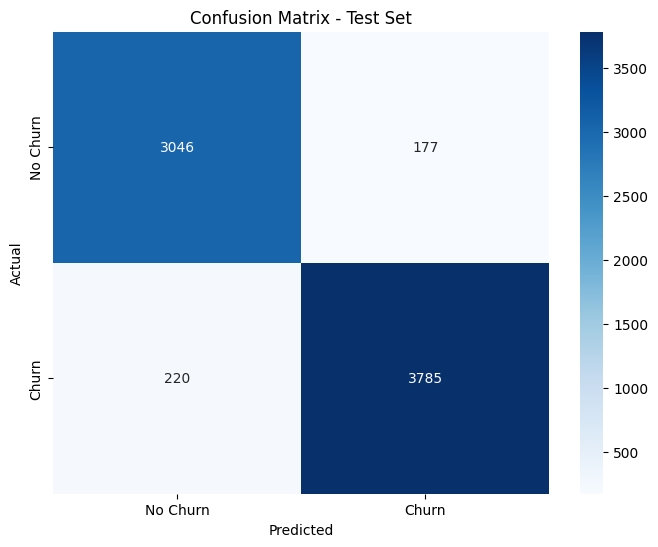


=== DETAILED CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

    No Churn       0.93      0.95      0.94      3223
       Churn       0.96      0.95      0.95      4005

    accuracy                           0.95      7228
   macro avg       0.94      0.95      0.94      7228
weighted avg       0.95      0.95      0.95      7228



In [55]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Churn', 'Churn'], 
            yticklabels=['No Churn', 'Churn'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Print detailed classification report
print("\n=== DETAILED CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

In [56]:
# Create comparison DataFrame
comparison_df = test_df[['churn']].copy()
comparison_df['predicted_churn'] = y_pred
comparison_df['churn_probability'] = y_pred_proba
comparison_df['prediction_correct'] = (comparison_df['churn'] == comparison_df['predicted_churn'])

# Show first 10 rows
print("=== ACTUAL VS PREDICTED CHURN COMPARISON (First 10 rows) ===")
print(comparison_df.head(10))

# Show summary statistics
print(f"\n=== PREDICTION SUMMARY ===")
print(f"Total test samples: {len(comparison_df)}")
print(f"Correct predictions: {comparison_df['prediction_correct'].sum()}")
print(f"Incorrect predictions: {(~comparison_df['prediction_correct']).sum()}")
print(f"Prediction accuracy: {comparison_df['prediction_correct'].mean():.4f}")

=== ACTUAL VS PREDICTED CHURN COMPARISON (First 10 rows) ===
   churn  predicted_churn  churn_probability  prediction_correct
0      1                1           0.999124                True
1      0                0           0.043263                True
2      1                1           0.997561                True
3      0                0           0.009286                True
4      1                1           0.990167                True
5      0                0           0.040103                True
6      1                1           0.999701                True
7      1                1           0.797664                True
8      1                1           0.999654                True
9      0                0           0.013890                True

=== PREDICTION SUMMARY ===
Total test samples: 7228
Correct predictions: 6831
Incorrect predictions: 397
Prediction accuracy: 0.9451


In [57]:
# Show some examples of correct and incorrect predictions
print("=== EXAMPLES OF CORRECT PREDICTIONS ===")
correct_predictions = comparison_df[comparison_df['prediction_correct'] == True].head(5)
print(correct_predictions)

print("\n=== EXAMPLES OF INCORRECT PREDICTIONS ===")
incorrect_predictions = comparison_df[comparison_df['prediction_correct'] == False].head(5)
print(incorrect_predictions)

=== EXAMPLES OF CORRECT PREDICTIONS ===
   churn  predicted_churn  churn_probability  prediction_correct
0      1                1           0.999124                True
1      0                0           0.043263                True
2      1                1           0.997561                True
3      0                0           0.009286                True
4      1                1           0.990167                True

=== EXAMPLES OF INCORRECT PREDICTIONS ===
     churn  predicted_churn  churn_probability  prediction_correct
44       1                0           0.233170               False
48       1                0           0.142179               False
69       1                0           0.040160               False
98       1                0           0.196829               False
112      0                1           0.856928               False
